In [1]:
import pathlib

from Domain.Nutzenergieanalyse import NEAData

import Bevoelkerung
import Domain.General
import Energiebilanz
import General
import Nutzenergieanalyse
import Processor
import Utils


def create_general_data(g_laender_factory: Domain.General.GLaenderFactory):
    g_sektoren_factory = General.GSektorenDefaultFactory()
    g_bereiche_factory = General.GBereicheSimpleFactory()
    g_energietraeger_klassen_factory = General.GEnergietraegerKlassenDefaultFactory()
    g_energietraeger_klassen = g_energietraeger_klassen_factory.create()
    g_energietraeger_factory = General.GEnergietraegerDefaultFactory(g_energietraeger_klassen)
    g_data_factory = General.GDataFactory(g_laender_factory, g_sektoren_factory, g_bereiche_factory,
                                          g_energietraeger_factory)
    g_data = g_data_factory.create()
    return g_data

def create_nea_data(g_data: Domain.General.GData):
    nea_data_factory = Nutzenergieanalyse.NEADataPickleFactory(pathlib.Path('Data/Serialization'))
    nea_data = nea_data_factory.create(g_data)
    return nea_data

def create_eb_data(g_data: Domain.General.GData):
    eb_laender_factory = Energiebilanz.EBLaenderDefaultFactory()
    eb_laender = eb_laender_factory.create(g_data.laender)
    eb_sektoren_factory = Energiebilanz.EBSektorenDefaultFactory(g_data.sektoren)
    eb_sektoren = eb_sektoren_factory.create()
    eb_data_factory = Energiebilanz.EBDataPickleFactory(pathlib.Path('Data/Serialization'))
    eb_energietraeger_factory = Energiebilanz.EBEnergietraegerDefaultFactory()
    eb_energietraeger = eb_energietraeger_factory.create(g_data)
    eb_data = eb_data_factory.create(eb_energietraeger, g_data)
    return eb_data

laender_factory = General.GBundeslaenderFactory()
general_data = create_general_data(laender_factory)

nea_dict_data = create_nea_data(general_data).data
nea_data = {land.name: {sektor.name: {bereich.name: nea_dict_data[land][sektor][bereich] for bereich in nea_dict_data[land][sektor].keys()} for sektor in nea_dict_data[land].keys()} for land in nea_dict_data.keys()}

eb_dict_data = create_eb_data(general_data).data
eb_data = {land.name: {sektor.name: eb_dict_data[land][sektor] for sektor in nea_dict_data[land].keys()} for land in eb_dict_data.keys()}



In [2]:
def reduce_braunkohle(data):
    braunkohle = data['Braunkohle'].fillna(0) + data['Braunkohlen-Briketts'].fillna(0)
    result = data.drop('Braunkohlen-Briketts', axis=1)
    result['Braunkohle'] = braunkohle
    return result

def handle_braunkohle(data):
    return {land: {sektor: {bereich: reduce_braunkohle(data[land][sektor][bereich]) for bereich in data[land][sektor].keys()} for sektor in data[land].keys()} for land in data.keys()}

nea_data = handle_braunkohle(nea_data)


In [3]:
def clean_negative_values(data):
    df = data.copy()
    df[df < 0] = 0
    return df

In [4]:
extrapolation = Utils.DFLinearExtrapolation()
extension = Utils.DFNanExtension()
extrapolation_extension = Utils.DFExtrapolationExtension(extrapolation)

In [5]:
def clean_after_braunkohle(data, sektor, bereich):
    if sektor != 'Wohngebäude':
        return data
    if bereich == 'Warmwasser und Kochen':
        return extension.run(data['1993':'2004'], data.index)
    if bereich == "Warmwasser":
        return extension.run(data['2005':], data.index)
    if bereich == "Kochen":
        return extension.run(data['2005':], data.index)
    return data

def handle_clean_after_braunkohle(data):
    return {land: {sektor: {bereich: clean_after_braunkohle(data[land][sektor][bereich], sektor, bereich) for bereich in data[land][sektor].keys()} for sektor in data[land].keys()} for land in data.keys()}

nea_data = handle_clean_after_braunkohle(nea_data)


<Axes: >

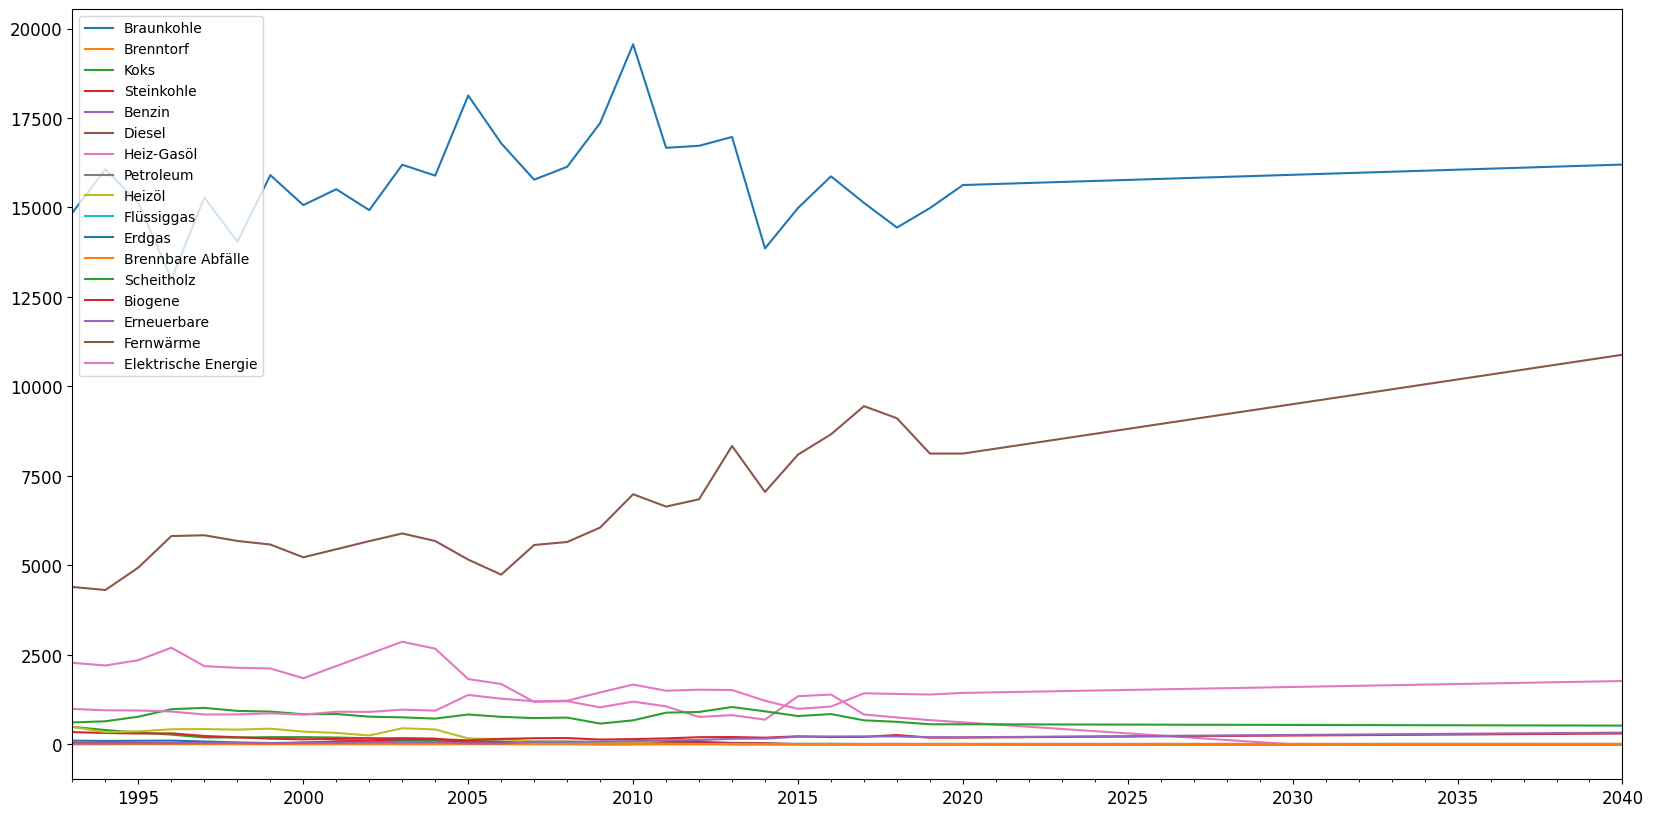

In [7]:
import matplotlib
import pandas as pd

matplotlib.rcParams["figure.figsize"] = (20,10)
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

#nea_data['wien']['Wohngebäude']['Heizen']
heizen_ph_wien = nea_data['wien']['Wohngebäude']['Heizen']
heizen_ph_wien_ex = extrapolation_extension.run(heizen_ph_wien, pd.PeriodIndex(pd.period_range(start=heizen_ph_wien.index[0], end='2040', freq='A'), name=heizen_ph_wien.index.name))
heizen_ph_wien_ex = clean_negative_values(heizen_ph_wien_ex)

heizen_ph_wien_ex.plot()

#clean_negative_values(heizen_ph_wien_ex.sum).plot()
#heizen_ph_wien


#szenario
# wien 2040 -> 0 gas
# 2035 -> 0 oel
# 2030 -> 0 kohle

#fernwaerme, strom, umweltwaereme -> 1,2,3% steigung
#scheitholz bleibt gleich
#wie entwickeln sich die anderen?
#individuell pro bundesland
#gesamtergebnis fuer oesterreich
